In [30]:
import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor


In [31]:
# CSV Datei lesen und bereinigen
df = pd.read_csv('allRunsAllFractions.csv')

dfTerranReg = df[df["fraction"] == "Terraner"]

# ungültige Spiele aussortieren
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]

# Lategame Spiele mit großer Streuung aussortieren
dfTerranReg = dfTerranReg[dfTerranReg["time"] < 750]

len(dfTerranReg)


2496

In [32]:
# Der Code wurde von der linearen Regression übernommen, daher diese Zuordnung
df2 = dfTerranReg.sample(frac=1)

len(df2)


2496

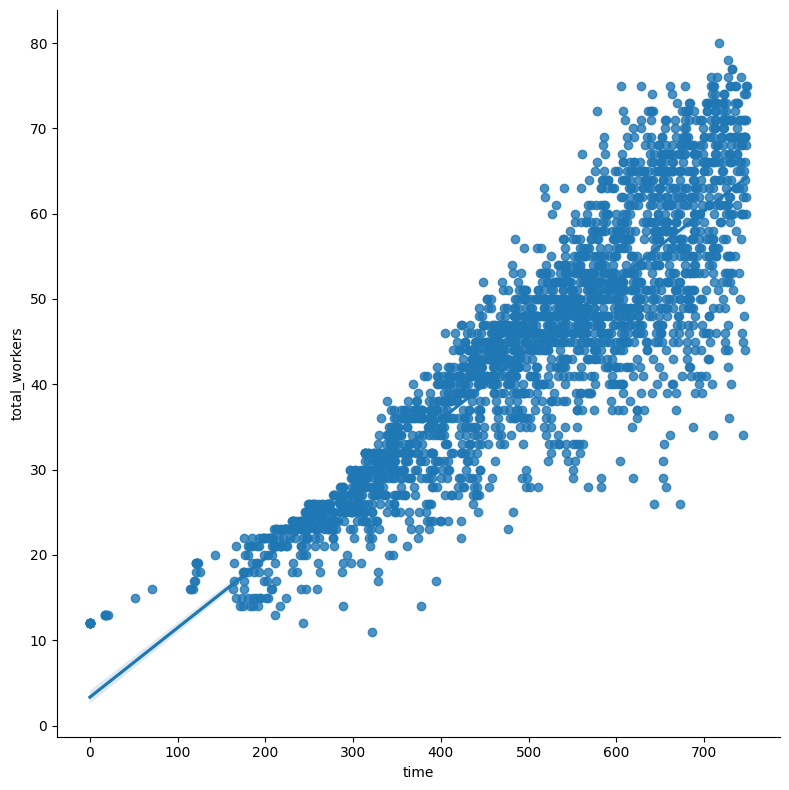

In [33]:
# Überprüfung der Signifikanz Arbeiter in frühen Spielphasen
g3= sns.lmplot(x="time", y="total_workers", order=1, data=df2,
          height=8)

In [34]:



X = df2[["total_workers"]]
y = df2["resource_mining"]

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

scaler = StandardScaler()
lin_reg = make_pipeline(scaler, MLPRegressor(random_state=1, max_iter=15000, learning_rate="adaptive"))
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


The R^2 value in the test set is 0.7045809470712636


In [35]:

dfTerran = df2.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army", "supply"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])
dfTerran


""
6114
6192
9076
5636
5345
...
5012
6303
6483
5286


In [36]:

feats = dfTerran
feats = pd.concat([w, feats], axis=1)
feats


,total_workers
6114,<gurobi.Var total_workers[6114]>
6192,<gurobi.Var total_workers[6192]>
9076,<gurobi.Var total_workers[9076]>
5636,<gurobi.Var total_workers[5636]>
5345,<gurobi.Var total_workers[5345]>
...,...
5012,<gurobi.Var total_workers[5012]>
6303,<gurobi.Var total_workers[6303]>
6483,<gurobi.Var total_workers[6483]>
5286,<gurobi.Var total_workers[5286]>


In [37]:


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Kostengleichung
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # untere Versorgungsgrenze
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # obere Versorgungsgrenze
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Model for pipe1:
501696 variables
254592 constraints
249600 general constraints
Input has shape (2496, 1)
Output has shape (2496, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
std_scaler1        (2496, 1)         2496         2496            0            0

dense1           (2496, 100)       499200       249600            0       249600 (relu)

dense2             (2496, 1)            0         2496            0            0


--------------------------------------------------------------------------------
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores,

In [38]:

outputs = pred_constr.input_values
pred_constr.input_values



,total_workers
6114,55.0
6192,55.0
9076,55.0
5636,55.0
5345,55.0
...,...
5012,55.0
6303,55.0
6483,55.0
5286,55.0
